### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib inline
from IPython.display import Audio
from scipy import stats
import scipy
from scipy.fft import fft, ifft,fftfreq

### Utility Functions

In [48]:
def glottal_excitation(oq,pitch,dur,fs,offset = 0):
  T0 = 1/pitch
  Ts = 1/fs
  period_samp_num = int(fs*T0)
  #single_excit = [750*(2*n*Ts-(3*((n*Ts)**2)/(oq*T0))) if n*Ts < oq*T0 else 0 for n in range(period_samp_num)]
  single_excit = [0.5e6*(((n*Ts)**2)-(((n*Ts)**3)/(oq*T0))) if n*Ts < oq*T0 else 0 for n in range(period_samp_num)]
  num_full_instances = int(dur*pitch)
  excit_sig = single_excit*num_full_instances + single_excit[:int(dur*pitch-int(dur*pitch)*period_samp_num)]
  excit_sig = np.array(excit_sig) + offset
  return excit_sig

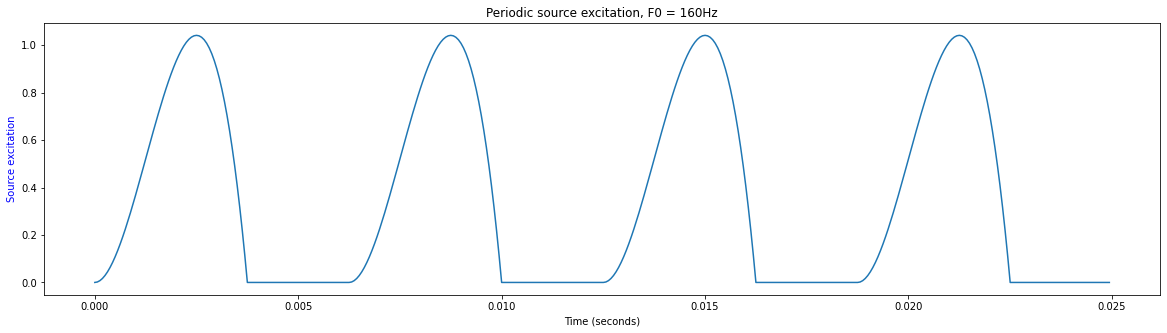

In [4]:
excit_sig = glottal_excitation(0.6,160,0.5,16000)
t_src = np.linspace(0,0.5,int(16000*0.5))
plt.figure(figsize=(20,5))
plt.plot(t_src[:400],excit_sig[:400])
plt.ylabel('Source excitation', color='b')
plt.xlabel('Time (seconds)')   
plt.title("Periodic source excitation, F0 = 160Hz")
plt.show()

In [5]:
def dft_plt(x,fs,db_plot=True):
  '''
  this function can be used to plot the magnitudea and the phase spectrum of an input signal
  x : input signal
  fs : sampling frequency
  db_plot : 'True' if we want to plot magnitude in dB 
  '''
  X = np.fft.fft(x) #getting the DFT coefficents of the signal 'x'
  T = 1/fs
  N=len(x) #number of samples
  f_dft = fftfreq(N,T) #Return the Discrete Fourier Transform sample frequencies
  N = len(X)

  X_abs = abs(X)
  X_phase = np.angle(X, deg=False)
  plt.figure(figsize=(12,4))

  y_label1 = "Magnitude"
  y_label2 = "Phase(radian)"
  title1 = 'Magnitude Spectrum'
  title2 = 'Phase Spectrum'
  if db_plot:
      X_abs = 20*np.log10(X_abs+1e-8)
      y_label1 += "(dB)" 
  # plotting the magnitude spectrum 
  #plt.subplot(1, 2, 1) 
  plt.plot(f_dft[:N//2],X_abs[:N//2]) 
  plt.title(title1)
  plt.xlabel("frequency(Hz)")
  plt.ylabel(y_label1)
  """  #plotting the phase spectrum
  plt.subplot(1, 2, 2) 
  plt.plot(f_dft[:N//2],X_phase[:N//2],'o') 
  plt.title(title2)
  plt.xlabel("frequency(Hz)")
  plt.ylabel(y_label2) 
  """     
  plt.show()
  return     

### Problem 01
---
Given the following specification for a single-formant resonator, obtain the transfer function of the filter $\mathrm{H}(\mathrm{z})$ from the relation between resonance frequency / bandwidth, and the pole angle / radius. Plot filter magnitude response ( $\mathrm{dB}$ magnitude versus frequency) and impulse response.

$\mathrm{F} 1($ formant $)=900 \mathrm{~Hz}$

B1(bandwidth $)=200 \mathrm{~Hz}$

Fs (sampling freq) $=16 \mathrm{kHz}$

### Solution
---
The resonators are two-pole filters where a pole near the unit circle causes the resonance. Designing a resonator filter can be done by following steps:
   For the given bandwidth *$B_1$* and the resonant frequency *$F_1$*, we calculate the pole radius *$R$* from the bandwidth.
\begin{align}
    R &= e^{-\pi B_1/f_s} 
\end{align}

  After that, we calculate the cosine of the pole angle θ:
\begin{align}
    \theta &= \frac{2 \pi F_1}{f_S}
\end{align}  
Then the gain factor $A_0$ is calculated. It makes the magnitude response unity at resonant frequency $F_1$.
\begin{align}
    A_0 &= (1-R^{2})sin \theta
\end{align} 

  Using the filter equation:

\begin{align}
 H(z) 
      &= \frac{A_0}{(1-Re^{j\theta} z^{-1})(1-Re^{j\theta} z^{-1})} \\
      &= \frac{A_0}{1-2 R cos\theta z^{-1}+R^{2}z^{-2}}
 \end{align}
 We can calculate the coefficients of the filters by comparing the equation below with our filter equation, as $b = [A_0]$ and $a = [1, -2 R cos\theta,R^{2}]$
\begin{align} 
  H(z) 
      &=  \frac{b[0]}{a[0]-a[1]z^{-1}+a[2]z^{-2}}
 \end{align}
Finally using the filter transfer function we calculate the impulse response using difference equation as:

\begin{align} 
  h[n] 
      &=  b[0]*\delta [n] - a[1]*h[n-1] - a[2]*h[n-2]
 \end{align}



In [6]:
def resonator_filter(f_r,b_r,fs): 
  '''
  This function gives us the filter coefficent of a 2nd order filter a set of two arrays
  f_r : resonance frequency
  b_r : resonance bandwidth
  fs : the sampling frequency 
  '''
  R = np.exp(-np.pi*b_r/fs) #the radius of the poles
  w_c = 2*np.pi*f_r #center frequency or resonance frequency
  theta = w_c/fs # the pole angle
  A0 = (1-R**2)*np.sin(theta) #gain factor to make the magnitude response unity at resonance frequency
  a = [1,-2*R*np.cos(theta),R**2] # coefficent of the denominator, [a0, a1, a2]
  b = [A0] # coefficient of the numerator, [b0]
  return b,a

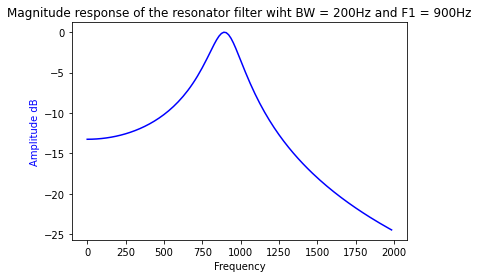

In [7]:
f_samp = 16000 # the sampling frequency

b,a = resonator_filter(900,200,f_samp)
w_1, H_1 = signal.freqz(b,a,fs=f_samp)
H_1_mag = abs(H_1)
H_1_db = 20*np.log10(abs(H_1))
wn = 2000 # frequency limit to be plotted
index_n = int(wn*len(w_1)/(f_samp/2))  # index corresponding to limiting frequency
plt.plot(w_1[:index_n],(H_1_db)[:index_n], 'b')
plt.ylabel('Amplitude dB', color='b')
plt.xlabel('Frequency')   
plt.title("Magnitude response of the resonator filter wiht BW = 200Hz and F1 = 900Hz")
plt.show()

In [8]:
def imp_resp(b,a,dur,fs):
  """
  Gives the impulse response for given 2nd order filter, given as filter coefficient arrays 
  """
  samp = int(dur*fs)
  h = np.zeros((samp))
  h[0] = b[0]/a[0]
  h[1] = -a[1]*h[0]/a[0]
  for n in range(2,samp):
    h[n] = -(a[1]*h[n-1]+a[2]*h[n-2])/a[0]  
  return h

In [9]:
duration = 0.01
h = imp_resp(b,a,duration,f_samp)
t = np.linspace(0,0.5,int(f_samp*duration))

Text(0.5, 1.0, 'Inpulse response of the resonator')

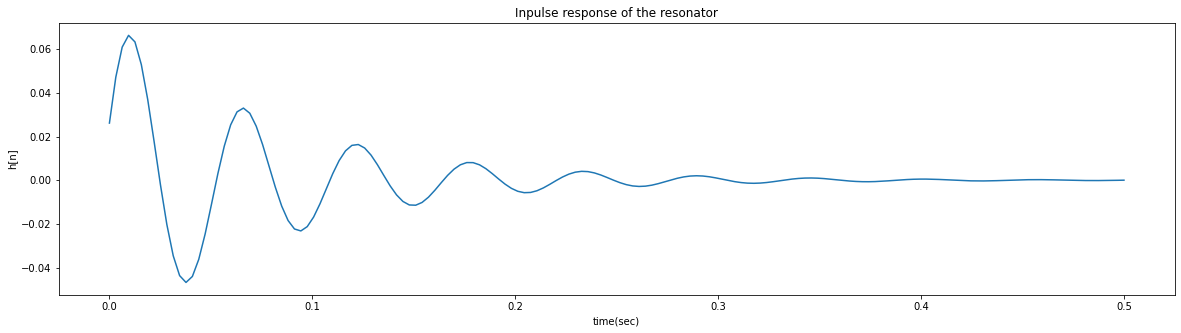

In [10]:
plt.figure(figsize=(20,5))
plt.plot(t,h)
plt.ylabel("h[n]")
plt.xlabel("time(sec)")
plt.title("Inpulse response of the resonator")

### Problem 02
---
Excite the above resonator ("filter") with a periodic source excitation of F0 $=160 \mathrm{~Hz}$. You can approximate the source signal by a narrow-triangular pulse train. Compute the output of the source-filter system over the duration of $0.5$ second using the difference equation implementation of the LTI system. Plot the time domain waveform over a few pitch periods so that you can observe waveform characteristics. Play out the $0.5 \mathrm{sec}$ duration sound and comment on the sound quality.
### Solution
---
Using the transfer function obtained previously - 
\begin{align} 
  H(z) 
      &=  \frac{b[0]}{a[0]-a[1]z^{-1}+a[2]z^{-2}}
 \end{align}
where $b = [A_0]$ and $a = [1, -2 R cos\theta,R^{2}]$
we can obtain the following difference equation for the filter:
\begin{align} 
  y[n] 
      &=  b[0]*x[n] - a[1]*y[n-1] - a[2]*y[n-2]
 \end{align}
 Using the above equation we can calculater the output sequence $y[n]$ for any input sequence $x[n]$ passed through our resonator.

In [11]:
def src_excit_gen(pitch,dur,pul_samp_width,f_samp):
  """
  Gives triangular source excitation signal for a given pitch, duration and sampling frequency of assigned width 
  """
  sigle_excit = np.zeros((1,int(f_samp*(1/pitch))))[0] #a period of the source excitation
  sigle_excit[:int(pul_samp_width/2) +1] = np.linspace(0,1,int(pul_samp_width/2) +1)
  sigle_excit[int(pul_samp_width/2) +1:pul_samp_width] = np.linspace(1,0,int(pul_samp_width/2) +1)[1:]
  sigle_excit = list(sigle_excit)
  src_excit = np.array(sigle_excit*int(dur*pitch)) # (dur*pitch_1) = number of instances of the excitation in 0.5s
  t_src = np.linspace(0,dur,int(f_samp*dur))
  return src_excit,t_src

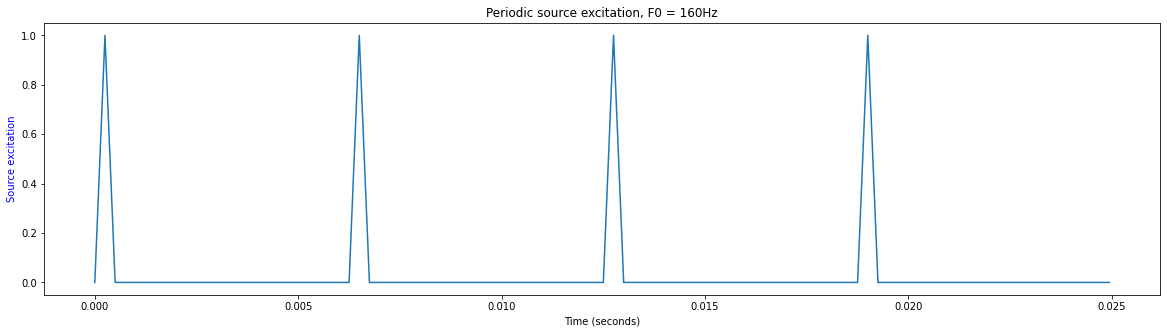

In [12]:
src_excit,t_src = src_excit_gen(160,0.5,9,f_samp)
plt.figure(figsize=(20,5))
plt.plot(t_src[:400],src_excit[:400])
plt.ylabel('Source excitation', color='b')
plt.xlabel('Time (seconds)')   
plt.title("Periodic source excitation, F0 = 160Hz")
plt.show()

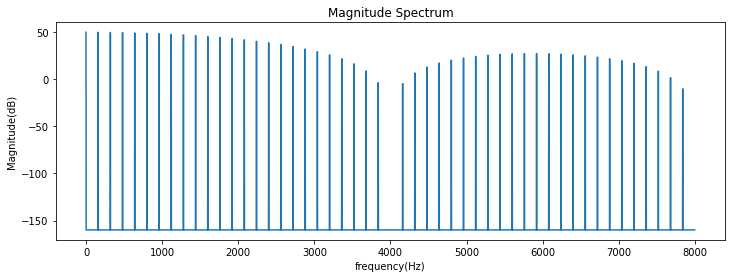

In [13]:
# Plotting the magnitude spectrum of the source excitation
x = src_excit
dft_plt(x,f_samp,db_plot=True)

In [14]:
def diff_filter(b,a,in_sig,fs):
  """
  Gives the output of a given 2nd order resonance filter to a given input using the difference equation 
  """
  samp = len(in_sig)
  out_sig = np.zeros_like(in_sig)
  out_sig[0] = b[0]*in_sig[0]/a[0]
  out_sig[1] = (b[0]*in_sig[1]-a[1]*out_sig[0])/a[0]
  for n in range(2,samp):
    out_sig[n] = (b[0]*in_sig[n] - a[1]*out_sig[n-1] - a[2]*out_sig[n-2])/a[0]
  return out_sig

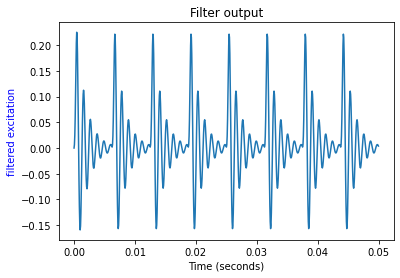

In [15]:
out_sig_diff_1 = diff_filter(b,a,src_excit,f_samp)
index = 800
plt.plot(t_src[:index],out_sig_diff_1[:index])
plt.title("Filter output")
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')   
Audio(out_sig_diff_1,rate=f_samp)

Magnitude Spectrum of The Filter Output


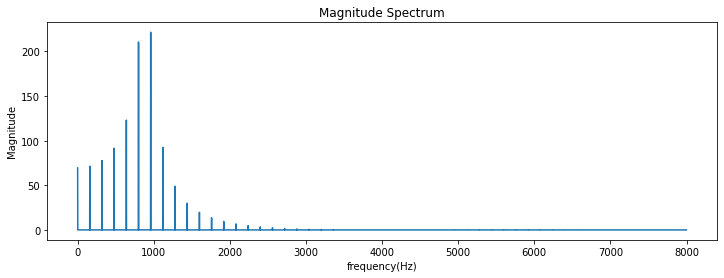

In [16]:
# Plotting the magnitude spectrum of the resonator output signal
x = out_sig_diff_1
print("Magnitude Spectrum of The Filter Output")
dft_plt(x,f_samp,db_plot=False)

#### Comment
---
The output signal kind of sounds like the horn of a vehicle. Looking at the magnitude spectrum of the output signal, we can confirm that it constitutes sinusoids with frequency multiple of the pitch of the excitation. Also, the energy of the sinusoidal component is dominant around the resonance frequency.

### Problem 03
---
Vary the parameters as indicated below; plot and comment on the differences in waveform and in sound quality for the different parameter combinations.

(a) $\mathrm{F} 0=120 \mathrm{~Hz}, \mathrm{~F} 1=300 \mathrm{~Hz}, \mathrm{~B} 1=100 \mathrm{~Hz}$

(b) $\mathrm{F} 0=120 \mathrm{~Hz}, \mathrm{~F} 1=1100 \mathrm{~Hz}, \mathrm{~B} 1=200 \mathrm{~Hz}$

(c) $\mathrm{F} 0=180 \mathrm{~Hz}, \mathrm{~F} 1=300 \mathrm{~Hz}, \mathrm{~B} 1=100 \mathrm{~Hz}$
### Solution
---

7980


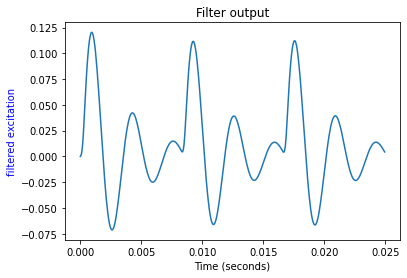

In [ ]:
f0,f1,b1 = 120,300,100
b,a = resonator_filter(f1,b1,f_samp)
src_excit,t_src = src_excit_gen(f0,0.5,9,f_samp)
out_sig_2 = diff_filter(b, a, src_excit,f_samp)
print(len(out_sig_2))
index = 400
plt.plot(t_src[:index],out_sig_2[:index])
plt.title("Filter output")
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')  
plt.show()
Audio(out_sig_2,rate=f_samp)

Magnitude Spectrum of The Filter Output


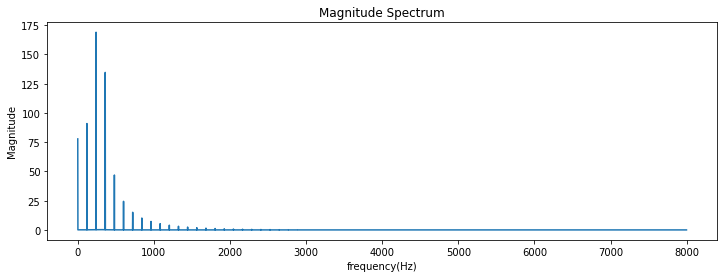

In [ ]:
# Plotting the magnitude spectrum of the resonator output signal
x = out_sig_2
print("Magnitude Spectrum of The Filter Output")
dft_plt(x,f_samp,db_plot=False)

7980


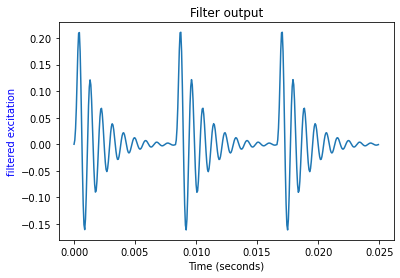

In [ ]:
f0,f1,b1 = 120,1100,200
b,a = resonator_filter(f1,b1,f_samp)
src_excit,t_src = src_excit_gen(f0,0.5,9,f_samp)
out_sig_3 = diff_filter(b, a, src_excit,f_samp)
print(len(out_sig_2))
index = 400
plt.plot(t_src[:index],out_sig_3[:index])
plt.title("Filter output")
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')  
plt.show()
Audio(out_sig_3,rate=f_samp)

Magnitude Spectrum of The Filter Output


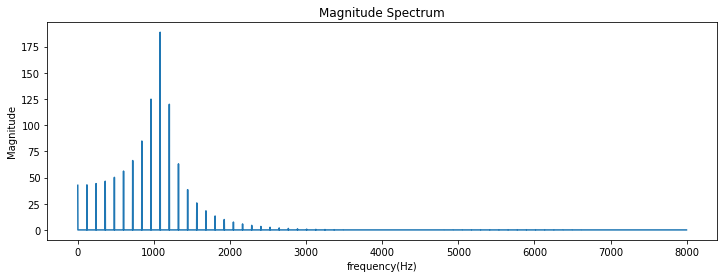

In [ ]:
# Plotting the magnitude spectrum of the resonator output signal
x = out_sig_3
print("Magnitude Spectrum of The Filter Output")
dft_plt(x,f_samp,db_plot=False)

7980


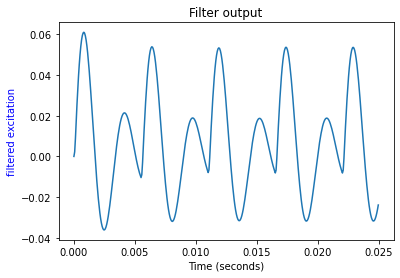

In [ ]:
f0,f1,b1 = 180,300,100
b,a = resonator_filter(f1,b1,f_samp)
src_excit,t_src = src_excit_gen(f0,0.5,5,f_samp)
out_sig_4 = signal.lfilter(b, a, src_excit)
print(len(out_sig_2))
index = 400
plt.title("Filter output")
plt.plot(t_src[:index],out_sig_4[:index])
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')  
plt.show()
Audio(out_sig_4,rate=f_samp)

Magnitude Spectrum of The Filter Output


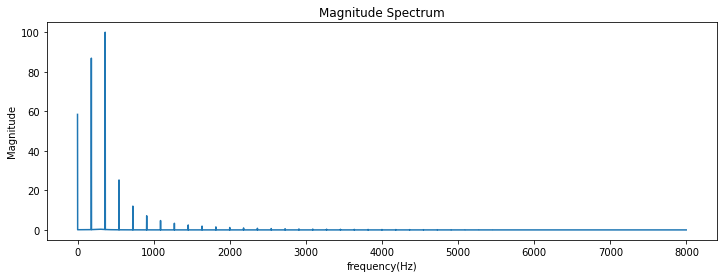

In [ ]:
# Plotting the magnitude spectrum of the resonator output signal
x = out_sig_4
print("Magnitude Spectrum of The Filter Output")
dft_plt(x,f_samp,db_plot=False)

[]

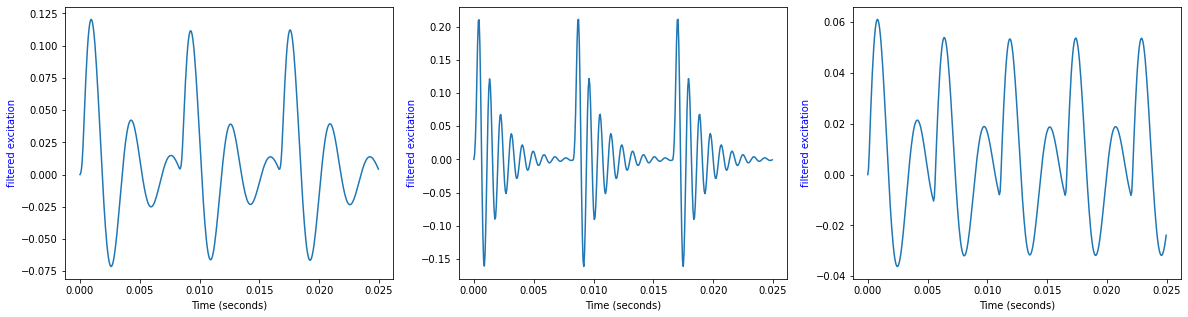

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(t_src[:index],out_sig_2[:index])
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')

plt.subplot(1,3,2)
plt.plot(t_src[:index],out_sig_3[:index])
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')

plt.subplot(1,3,3)
plt.plot(t_src[:index],out_sig_4[:index])
plt.ylabel('filtered excitation', color='b')
plt.xlabel('Time (seconds)')
plt.plot()

#### Comment
---
From the above plot of the different waveform output, we can observe that:
1. The shape of the waveform of the 1st and 3rd outputs is pretty alike. Both differ in shape from the 2nd waveform. The 2nd waveform varies quite fastly compared to the other two waveforms. Also, the amplitude of the 2nd wave decays down faster, within a period, compared to the other two.
2. The period of the 1st and 2nd outputs is similar and more than the 3rd.

To me, subjectively, the sound of the 1st and the 3rd output sounded relatively similar compared to the 2nd output. I was able to distinguish the 2nd sound from the other two easily. It took me a closer examination to resolve the 1st and the 3rd waveform audio.

### Problem 04
---
In place of the simple single-resonance signal, synthesize the following more realistic vowel sounds at two distinct pitches (F0 $=120 \mathrm{~Hz}, \mathrm{~F} 0=220 \mathrm{~Hz}$ ). Keep the bandwidths constant at 100 $\mathrm{Hz}$ for all formants. Duration of sound: $0.5 \mathrm{sec}$. Comment on the sound quality across the different sounds. Plot a few periods of any 2 examples.

Vowel F1, F2, F3

/a/ $730,1090,2440$

/i/ $270,2290,3010$

u/ $300,870,2240$

(Optional: Use glottal pulse shaping and lip radiation filtering. Add a small amount of aspiration noise and pitch jitter to enhance naturalness.)
#### Solution
---
A cascade connection configuration of the formant resonators to stimulate the transfer function of the vocal tract is employed to synthesize the vowel waveform. The advantage of the cascade configuration is that the relative amplitude of the peaks for vowels turns out right without needing individual amplitude controls for each format
#### /a/ as in Hot

In [144]:
def synthesize_vowel(f0,bw,f1,f2,f3,pulse_w,dur,fs):
  """
  for given input parameter of three formant model gives the synthesized vowel waveform
  """
  b1,a1 = resonator_filter(f1,bw,f_samp)
  b2,a2 = resonator_filter(f2,bw,f_samp)
  b3,a3 = resonator_filter(f3,bw,f_samp)
  src_excit,ts = src_excit_gen(f0,dur,pulse_w,fs)
  vow_sig = diff_filter(b1, a1, src_excit,fs)
  vow_sig = diff_filter(b2, a2, vow_sig,fs)
  vow_sig = diff_filter(b3, a3, vow_sig,fs)
  sos_arr = [[b1[0],0,0,a1[0],a1[1],a1[2]],[b2[0],0,0,a2[0],a2[1],a2[2]],[b3[0],0,0,a3[0],a3[1],a3[2]]]
  ts = np.linspace(0,dur,len(vow_sig))
  return vow_sig,ts,sos_arr

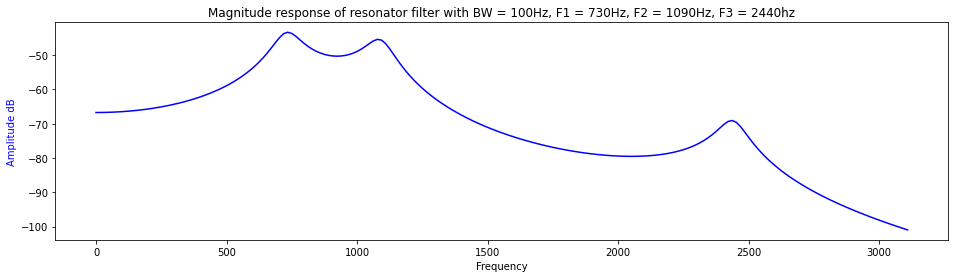

In [145]:
f0,bw,f1,f2,f3 = 120,100,730,1090,2440
vow_sig_1,t_src,sos_arr = synthesize_vowel(f0,bw,f1,f2,f3,9,0.5,f_samp)
f0 = 220
vow_sig_2,t_src,sos_arr = synthesize_vowel(f0,bw,f1,f2,f3,9,0.5,f_samp)

wn = 200
w_1, H_1 = signal.sosfreqz(sos_arr,fs=f_samp)
H_1_mag = abs(H_1)
H_1_db = 20*np.log10(abs(H_1))

plt.figure(figsize=(16,4))
plt.plot(w_1[:wn],(H_1_db)[:wn], 'b')
plt.title("Magnitude response of resonator filter with BW = 100Hz, F1 = 730Hz, F2 = 1090Hz, F3 = 2440hz")
plt.ylabel('Amplitude dB', color='b')
plt.xlabel('Frequency') 
plt.show()

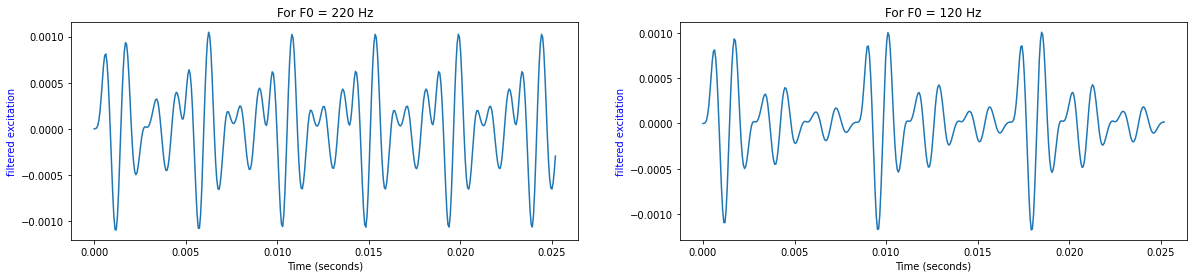

In [146]:
index = 400
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.plot(t_src[:index],vow_sig_2[:index])
plt.ylabel('filtered excitation', color='b')
plt.title("For F0 = 220 Hz")
plt.xlabel('Time (seconds)')

plt.xlabel('Time (seconds)')
plt.subplot(1, 2, 2)
plt.plot(t_src[:index],vow_sig_1[:index])
plt.ylabel('filtered excitation', color='b')
plt.title("For F0 = 120 Hz")
plt.xlabel('Time (seconds)')  
plt.show()

Magnitude Spectrum of The Filter Output for 120Hz


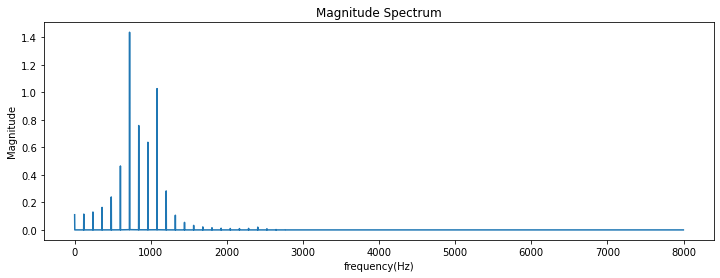

In [147]:
# Plotting the magnitude spectrum of the resonator output signal
x = vow_sig_1
print("Magnitude Spectrum of The Filter Output for 120Hz")
dft_plt(x,f_samp,db_plot=False)

Magnitude Spectrum of The Filter Output for 220Hz


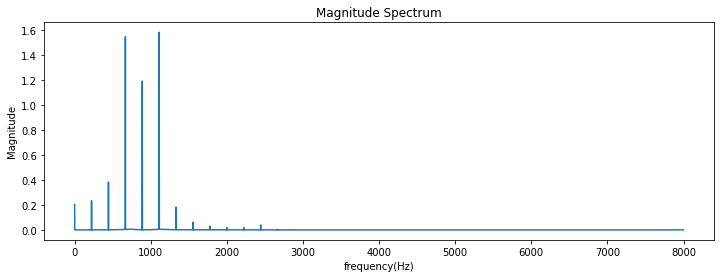

In [148]:
# Plotting the magnitude spectrum of the resonator output signal
x = vow_sig_2
print("Magnitude Spectrum of The Filter Output for 220Hz")
dft_plt(x,f_samp,db_plot=False)

In [149]:
print("For F0 = 120Hz")
Audio(vow_sig_1,rate=f_samp)

For F0 = 120Hz


In [23]:
print("For F0 = 220Hz")
Audio(vow_sig_2,rate=f_samp)

For F0 = 220Hz


#### /i/ as in Beet

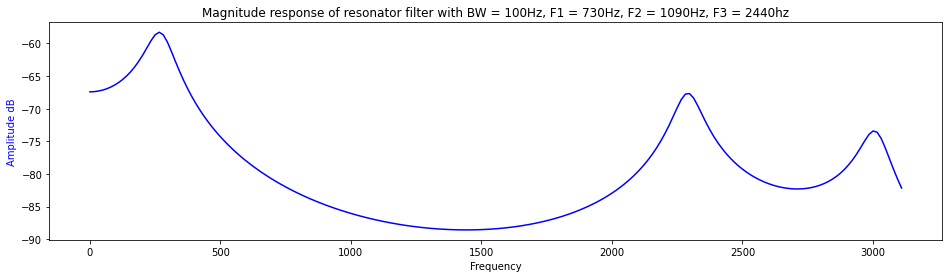

In [24]:

f0,bw,f1,f2,f3 = 120,100,270,2290,3010
vow_sig_1,t_src,sos_arr = synthesize_vowel(f0,bw,f1,f2,f3,9,0.5,f_samp)
f0 = 220
vow_sig_2,t_src,sos_arr = synthesize_vowel(f0,bw,f1,f2,f3,9,0.5,f_samp)

wn = 200
w_1, H_1 = signal.sosfreqz(sos_arr,fs=f_samp)
H_1_mag = abs(H_1)
H_1_db = 20*np.log10(abs(H_1))

plt.figure(figsize=(16,4))
plt.plot(w_1[:wn],(H_1_db)[:wn], 'b')
plt.title("Magnitude response of resonator filter with BW = 100Hz, F1 = 730Hz, F2 = 1090Hz, F3 = 2440hz")
plt.ylabel('Amplitude dB', color='b')
plt.xlabel('Frequency') 
plt.show()

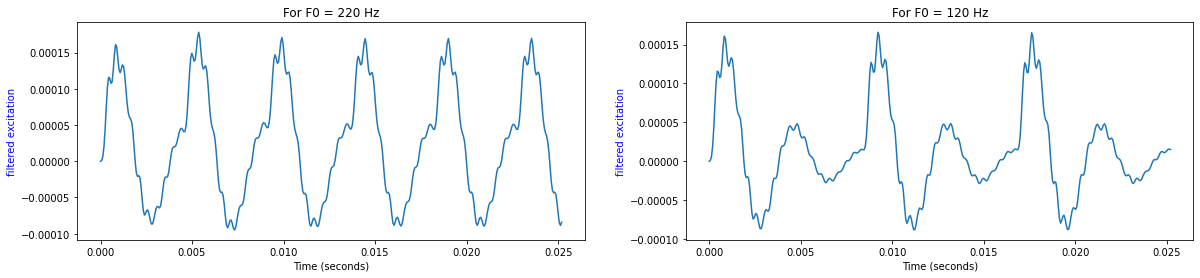

In [25]:
index = 400
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.plot(t_src[:index],vow_sig_2[:index])
plt.ylabel('filtered excitation', color='b')
plt.title("For F0 = 220 Hz")
plt.xlabel('Time (seconds)')

plt.xlabel('Time (seconds)')
plt.subplot(1, 2, 2)
plt.plot(t_src[:index],vow_sig_1[:index])
plt.ylabel('filtered excitation', color='b')
plt.title("For F0 = 120 Hz")
plt.xlabel('Time (seconds)')  
plt.show()

Magnitude Spectrum of The Filter Output for 120Hz


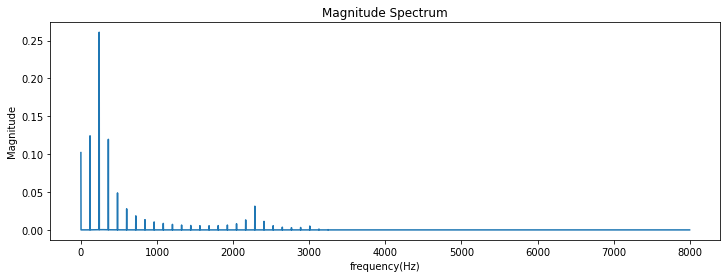

In [26]:
# Plotting the magnitude spectrum of the resonator output signal
x = vow_sig_1
print("Magnitude Spectrum of The Filter Output for 120Hz")
dft_plt(x,f_samp,db_plot=False)

Magnitude Spectrum of The Filter Output for 220Hz


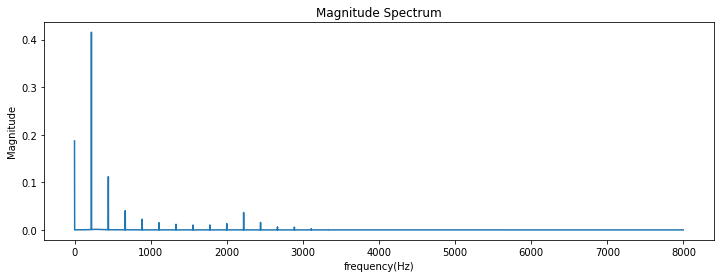

In [27]:
# Plotting the magnitude spectrum of the resonator output signal
x = vow_sig_2
print("Magnitude Spectrum of The Filter Output for 220Hz")
dft_plt(x,f_samp,db_plot=False)

In [28]:
print("For F0 = 120Hz")
Audio(vow_sig_1,rate=f_samp)

For F0 = 120Hz


In [29]:
print("For F0 = 220Hz")
Audio(vow_sig_2,rate=f_samp)

For F0 = 220Hz


#### /u/ as in Boot

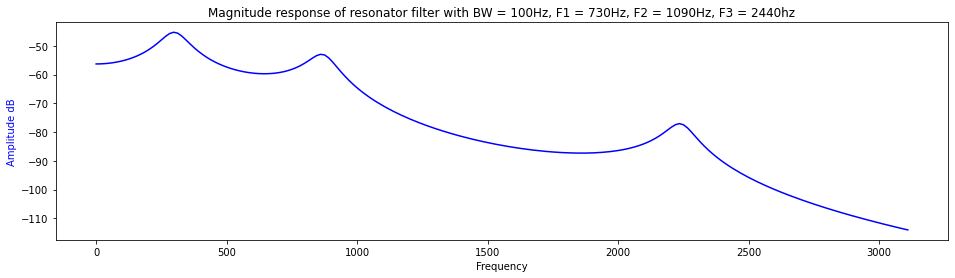

In [30]:
f0,bw,f1,f2,f3 = 120,100,300,870,2240
vow_sig_1,t_src,sos_arr = synthesize_vowel(f0,bw,f1,f2,f3,9,0.5,f_samp)
f0 = 220
vow_sig_2,t_src,sos_arr = synthesize_vowel(f0,bw,f1,f2,f3,9,0.5,f_samp)

wn = 200
w_1, H_1 = signal.sosfreqz(sos_arr,fs=f_samp)
H_1_mag = abs(H_1)
H_1_db = 20*np.log10(abs(H_1))

plt.figure(figsize=(16,4))
plt.plot(w_1[:wn],(H_1_db)[:wn], 'b')
plt.title("Magnitude response of resonator filter with BW = 100Hz, F1 = 730Hz, F2 = 1090Hz, F3 = 2440hz")
plt.ylabel('Amplitude dB', color='b')
plt.xlabel('Frequency') 
plt.show()

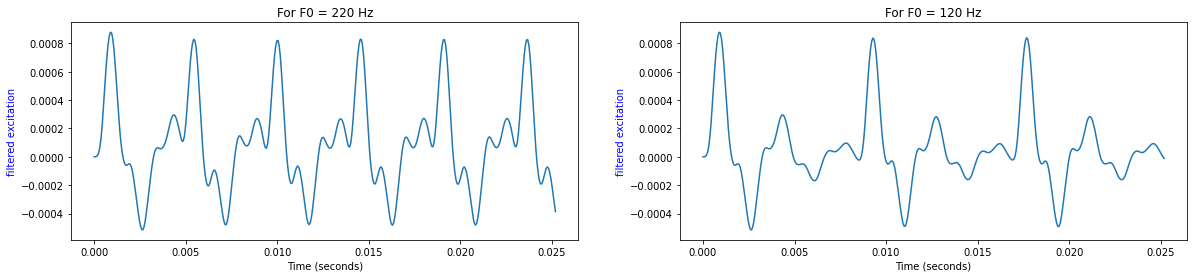

In [31]:
index = 400
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.plot(t_src[:index],vow_sig_2[:index])
plt.ylabel('filtered excitation', color='b')
plt.title("For F0 = 220 Hz")
plt.xlabel('Time (seconds)')

plt.xlabel('Time (seconds)')
plt.subplot(1, 2, 2)
plt.plot(t_src[:index],vow_sig_1[:index])
plt.ylabel('filtered excitation', color='b')
plt.title("For F0 = 120 Hz")
plt.xlabel('Time (seconds)')  
plt.show()

Magnitude Spectrum of The Filter Output for 120Hz


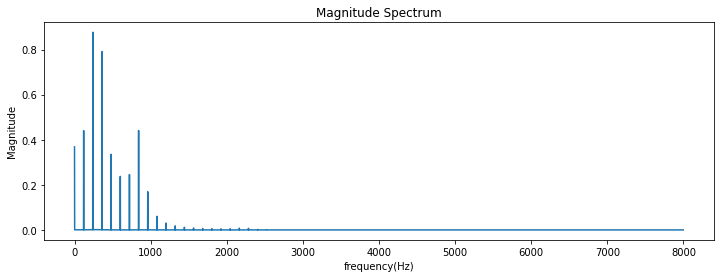

In [32]:
# Plotting the magnitude spectrum of the resonator output signal
x = vow_sig_1
print("Magnitude Spectrum of The Filter Output for 120Hz")
dft_plt(x,f_samp,db_plot=False)

Magnitude Spectrum of The Filter Output for 220Hz


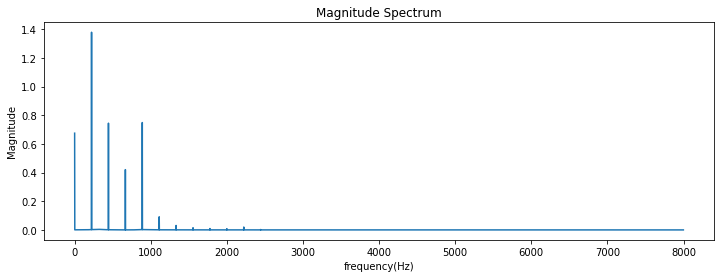

In [33]:
# Plotting the magnitude spectrum of the resonator output signal
x = vow_sig_2
print("Magnitude Spectrum of The Filter Output for 220Hz")
dft_plt(x,f_samp,db_plot=False)

In [34]:
print("For F0 = 120Hz")
Audio(vow_sig_1,rate=f_samp)

For F0 = 120Hz


In [35]:
print("For F0 = 220Hz")
Audio(vow_sig_2,rate=f_samp)

For F0 = 220Hz


### Comment 
---
The sound outputs of the given three different filters are easily distinguishable. We can hear a distinct phonetic sound as output for each set of parameters. This sound seems characteristic of those particular filter parameters and is preserved for the two different pitch frequencies. It is not to say that the sound output for the two different pitches sounds similar, but they sound identical phonetically. 

## Golttal pulse shaping ,radiation filter, modulated aspiratory noise and pitch jitter

### Implementation of different modules of the Vowel prouction model 

Reference : Aspiration noise during phonation : synthesis, analysis, and pitch-scale modification ([Link](https://dspace.mit.edu/handle/1721.1/47819))

Function implementing Jitter and golttal shaping

In [105]:
def glottal_excitation_with_jitter(jit_per,oq,pitch,dur,fs,offset = 0):
  """
  This function output the glottal flow velocity signal, with pitch jitter, for a given input duration.
  PARAMETERS - 
  jit_per : the maximum jitter percent
  oq : the open quotient. ictates the open phase dduration (oq/f0) within a glottal cycle
  pitch : the pitch for the glottle vibration
  dur : duration of the required glottal waveform
  fs : sampling frequency
  offset : this parameters controls the amount of noise during the closed phase. 
  """
  Ts = 1/fs
  total_samp = fs*dur
  samp_count = 0
  excit_sig = []
  while samp_count<total_samp:
    T0 = 1/pitch + (jit_per*(1/pitch)/100)*(2*np.random.uniform()-1) # adding jitter- varying the pitch period
    period_samp_num = int(fs*T0)
    samp_count += period_samp_num
    single_excit = [0.5e6*(((n*Ts)**2)-(((n*Ts)**3)/(oq*T0))) if n*Ts < oq*T0 else 0 for n in range(period_samp_num)]
    excit_sig += single_excit 
  excit_sig = np.array(excit_sig) + offset # adding DC offset
  return excit_sig

Function implementing the Radiation characteristic

In [106]:
def radiation_fil(input_sig):
  """
  This function implements a first difference filter based approxiamtion of the radiation characteristic 
  input_sig : the input signal to the radiation filter
  """
  input_sig = np.array(input_sig)
  output_sig = np.diff(input_sig)
  return output_sig

Function for the vocal tract filter

In [120]:
def vocal_tract_filter(tract_param,in_sig,fs):
  bw,f1,f2,f3 = tract_param
  b1,a1 = resonator_filter(f1,bw,fs)
  b2,a2 = resonator_filter(f2,bw,fs)
  b3,a3 = resonator_filter(f3,bw,fs)

  out_sig = diff_filter(b1, a1, in_sig,fs)
  out_sig = diff_filter(b2, a2, out_sig,fs)
  out_sig = diff_filter(b3, a3, out_sig,fs)

  return out_sig

**The Vowel production model pipeline**

In [121]:
def vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000):
  g_n = glottal_excitation_with_jitter(jit_per,oq,pitch,dur,fs,offset = 0) # glottal flow velocity waveform
  asp_noise = np.random.normal(0, sigma_noise, len(g_n))*g_n # moddulated aspiratory noise waveform

  xp_n = vocal_tract_filter(tract_param,g_n,fs) # output signal at the lip due to the periodic source
  xn_n = vocal_tract_filter(tract_param,asp_noise,fs) # output signal at the lip due to the noise source

  s_n = radiation_fil(xp_n) + radiation_fil(xn_n) # total speech pressure signal at the receiver as a linear combination of
  # the periodic and noise component

  return s_n

### Outputs and Results

Glottoal Flow Pulse

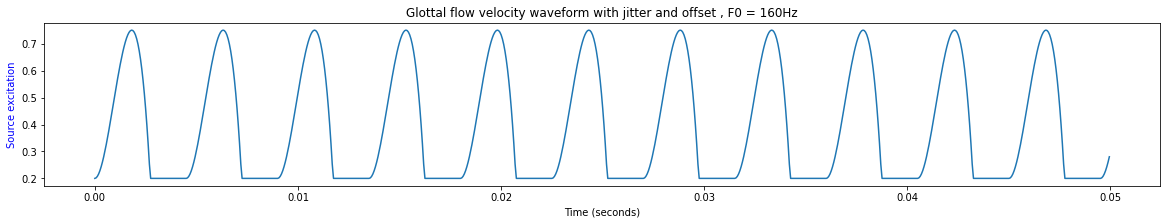

In [122]:
dur = 0.5 # duration of the excitation signal
f0  = 160 # the pitch frequency
g_n = glottal_excitation_with_jitter(6,0.6,f0,dur,f_samp,offset=0.2) # glottal flow velocity waveform 
t_src = np.linspace(0,0.5,int(f_samp*dur))
plt.figure(figsize=(20,3))
plt.plot(t_src[:800],excit_sig[:800])
plt.ylabel('Source excitation', color='b')
plt.xlabel('Time (seconds)')   
plt.title("Glottal flow velocity waveform with jitter and offset , F0 = 160Hz")
plt.show()

Modulated Aspiratory Noise

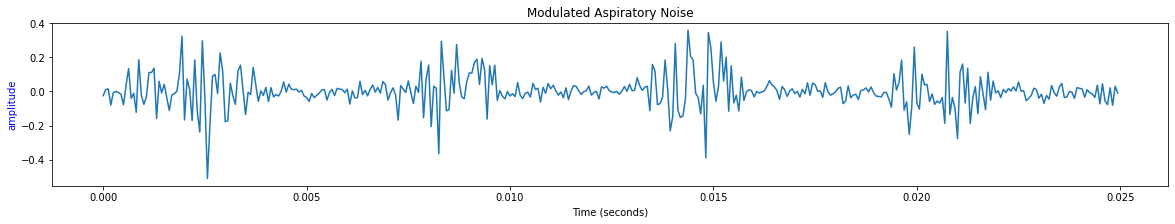

In [123]:
mu, sigma = 0, 0.15 # mean and standard deviation
asp_noise = np.random.normal(mu, sigma, len(g_n))*g_n
plt.figure(figsize=(20,3))
plt.plot(t_src[:400],asp_noise[:400])
plt.ylabel('amplitude', color='b')
plt.xlabel('Time (seconds)')   
plt.title("Modulated Aspiratory Noise")
plt.show()

/a/

In [124]:
pitch = 120
tract_param = (100,730,1090,2440) # /a/
jit_per, oq , dur, offset,sigma_noise= 6, 0.6, 0.5, 0.2,0.05 # 6% maximum pitch jitter
s_n_male_a = vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000)
pitch = 220
s_n_female_a = vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000)

**Audio output**

In [126]:
print("For F0 = 120Hz")
Audio(s_n_male_a,rate=f_samp)

For F0 = 120Hz


In [127]:
print("For F0 = 220Hz")
Audio(s_n_female_a,rate=f_samp)

For F0 = 220Hz


/i/

In [137]:
pitch = 120
tract_param = (100,270,2290,3010) # /i/
jit_per, oq , dur, offset,sigma_noise= 6, 0.6, 0.5, 0.2,0.05 # 6% maximum pitch jitter
s_n_male_a = vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000)
pitch = 220
s_n_female_a = vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000)

Audio output

In [138]:
print("For F0 = 120Hz")
Audio(s_n_male_a,rate=f_samp)

For F0 = 120Hz


In [139]:
print("For F0 = 220Hz")
Audio(s_n_female_a,rate=f_samp)

For F0 = 220Hz


**/u/**

In [140]:
pitch = 120
tract_param = (100,300,870,2240) #/u/
jit_per, oq , dur, offset,sigma_noise= 6, 0.6, 0.5, 0.2,0.05 # 6% maximum pitch jitter
s_n_male_a = vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000)
pitch = 220
s_n_female_a = vowel_production_model(jit_per,oq,pitch,dur,offset,sigma_noise,tract_param,fs=16000)

**Audio output**

In [141]:
print("For F0 = 120Hz")
Audio(s_n_male_a,rate=f_samp)

For F0 = 120Hz


In [142]:
print("For F0 = 220Hz")
Audio(s_n_female_a,rate=f_samp)

For F0 = 220Hz
